# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from scipy import stats
from collections import Counter
colors = np.array(["#377eb8","#ff7f00",  ])

# Импорт данных

Датасет про предсказание возраста жемчужных раковин:
https://www.kaggle.com/datasets/rodolfomendes/abalone-dataset/data

Возраст здесь это количество колец Rings + 1,5.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/3 sem/out_det/abalone.csv')
data.columns = [column_name.lower().replace(' ', '_') for column_name in data]
data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# Функции

In [ ]:
def plot_data(ax,X,n_inliers,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    """Визуализация двумерных  данных для поиска аномалий
    Входные переменные:
    ===========
    ax: отдельная ячейка объекта figure
    X: набор данных, содержащий признаки X
    n_inliers: количество нормальных данных
    name: название графика
    marker: тип маркера - по умолчанию просто круги
    colors: цвета, которые будут использоваться для раскраски разных классов - по умолчанию Красный и Синий
    alpha: прозрачность маркеров
    s: размер маркера (~ квадрат радиуса)
    facecolor:
    """


    ax.set_title(name, fontsize = 30) # прописываем название графика
    ax.scatter(X[:n_inliers, 0], X[:n_inliers, 1],
                marker = marker, c=colors[0],
                s = s,
                alpha =alpha)
    ax.scatter(X[n_inliers:, 0], X[n_inliers:, 1],
            marker = marker, c=colors[1],
            s = s,
            alpha =alpha)
    # немного красоты и аккуратности
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
def viz_anomaly(data, algorithm, colors, n_inliers, response_method="auto"):
    """Визуализация принятия решений и данных
    Входные переменные:
    ===========
    data: данные которые будем визуализировать
    algorithm: Класс модели машинного обучения для которого мы хотим узнать границы решений
    colors: цвета, которые будут использоваться для раскраски разных классов
    n_inliers: количество нормальных точек в штуках
    response_method: что визуализируем, результаты метода decision_function, predict_proba или predict. auto перебирает первый возможный вариант
    """

    cm_bright = ListedColormap(colors[::-1]) # формируем цветовую карту из наших цветов

    # отрисовываем границу принятия решений с помощью Класса библиотеки scikit-learn
    disp = DecisionBoundaryDisplay.from_estimator(
        algorithm, # Какой алгоритм используем
        data, # на каких данных проверяем
        response_method=response_method, # что визуализируе
        cmap=cm_bright, # какую цветовую карту используем
        alpha=0.5, #прозрачность
    )

    # визуализируем просто данные с помощью нашей функции
    plot_data(disp.ax_,data,n_inliers, colors = colors,)

# EDA

In [ ]:
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Имеем один категориальный признак, и 6 числовых признаков. Пропущенных значений нет

In [ ]:
data[data.duplicated()]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


Повторяющихся данных также нет. Выберем только числовые признаки:

In [ ]:
use_data = data[[column for column in data.columns if column not in ['sex', 'rings']]]
use_data.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


Посмотрим на распределения:

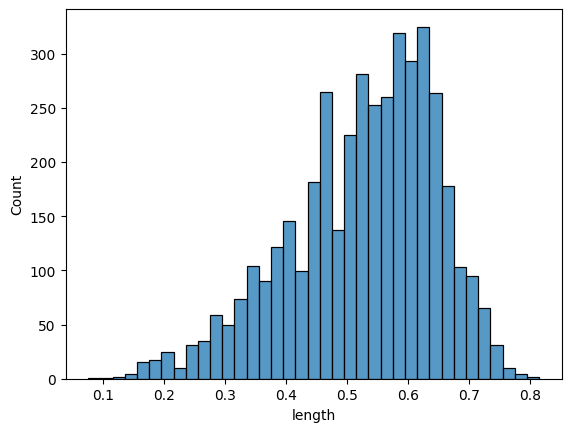

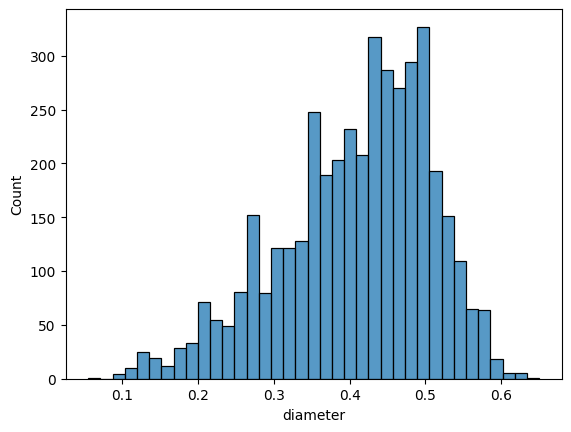

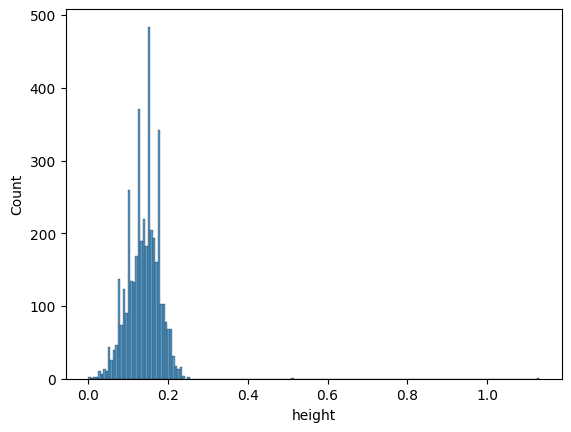

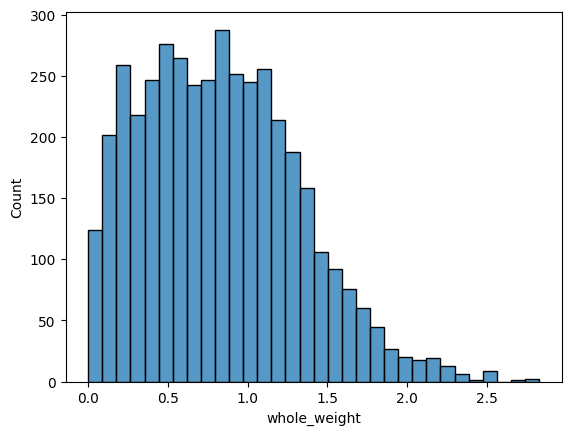

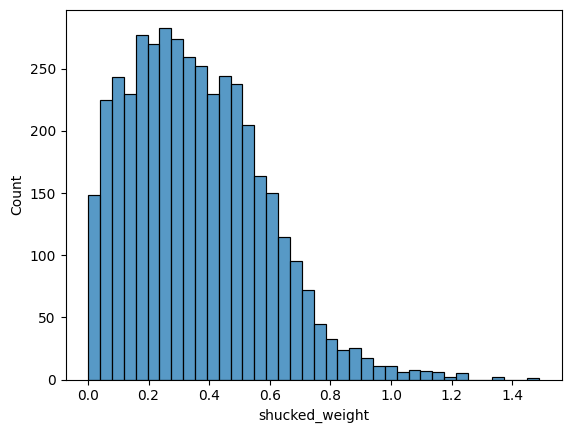

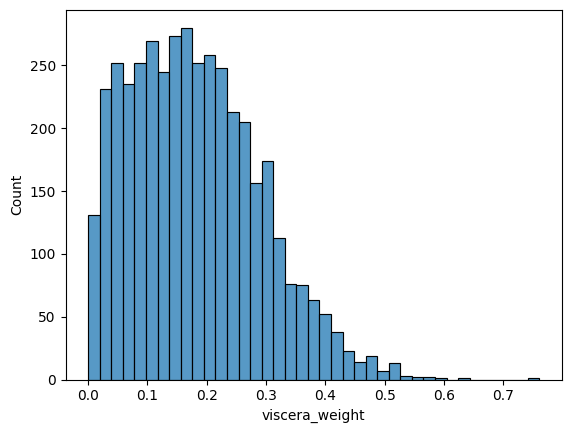

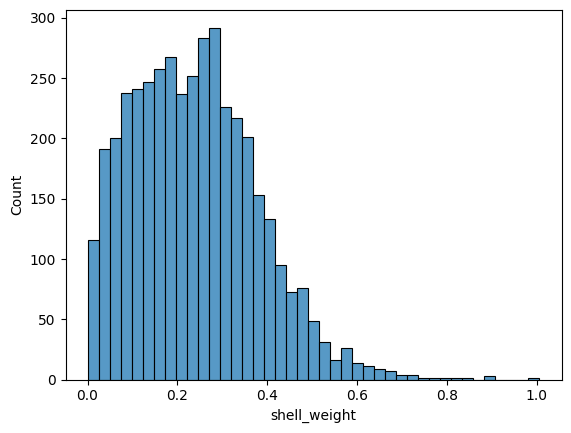

In [ ]:
for col in use_data.columns:
  sns.histplot(use_data[col])
  plt.show()

Посмотрим поближен на высоту:

<Axes: xlabel='height', ylabel='Count'>

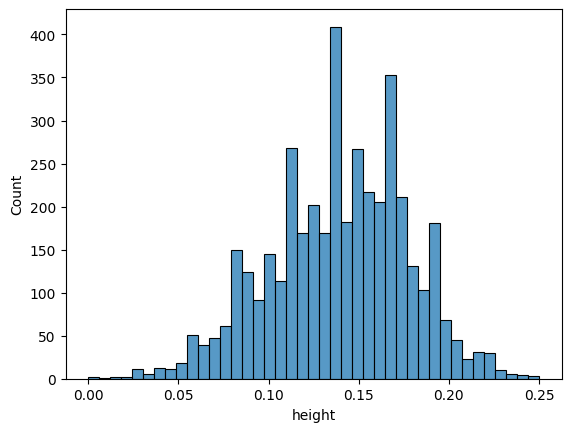

In [ ]:
sns.histplot(use_data[use_data.height<=0.3].height)

Большинство фич, похоже, имеют бета-распределения.
А на нормальное распределение чем-то похоже только распределие высоты. Проверим гипотезу о том, что действительно нормальное распределение. Пусть уровень значимости 0.5:

In [ ]:
res = stats.normaltest(use_data.height.values)
res.pvalue

0.0

In [ ]:
res = stats.normaltest(use_data[use_data.height<=0.3].height.values)
res.pvalue

9.42092652032261e-12

Есть основания отвергнуть нулевую гипотезу, тогда высота также распределена не по нормальному закону.

# train-test split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(use_data, data.rings, test_size=0.3, random_state=1)

In [ ]:
X_train.shape

(2923, 7)

In [ ]:
X_test.shape

(1254, 7)

# Но раз уж пришли, то все же попробуем EllipticEnvelope

## на train

Для этого дополнительно сгенерируем нормально распределенные данные c теми же параметрами, но без выбросов, на фоне которых будем смотреть на фичу:

<Axes: ylabel='Count'>

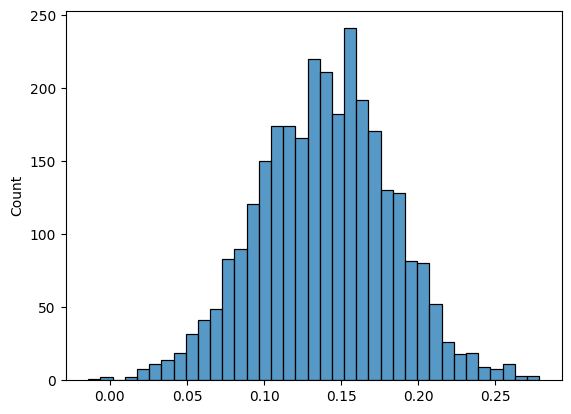

In [ ]:
norm = np.random.normal(loc=X_train.height.values.mean(), scale=X_train.height.values.std(), size=X_train.shape[0])
sns.histplot(norm)

In [ ]:
data = pd.concat([X_train.height, pd.Series(norm, name='norm', index=X_train.height.index)], axis=1)
data.head()

,height,norm
3213,0.140,0.159844
4080,0.125,0.160815
1891,0.145,0.090552
3566,0.155,0.128217
3438,0.105,0.094647


<Axes: xlabel='height', ylabel='norm'>

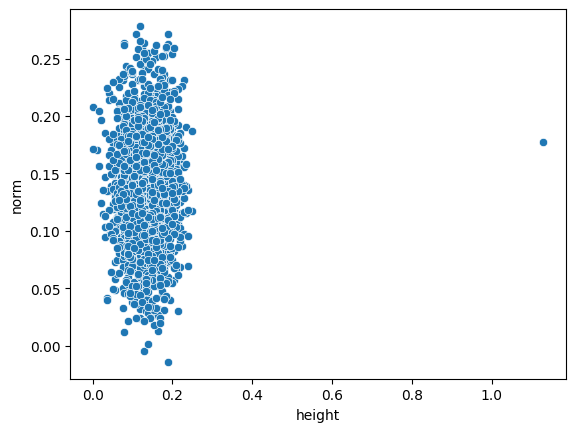

In [ ]:
sns.scatterplot(x=data.height, y=data.norm)

То же без выброса для ясности:

<Axes: xlabel='height', ylabel='norm'>

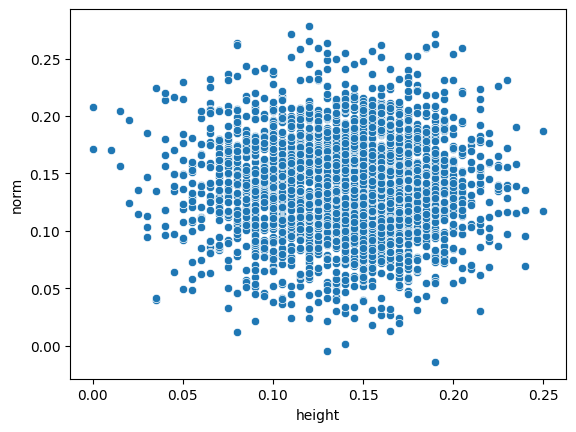

In [ ]:
sns.scatterplot(x=data.height[data.height<=0.4], y=data.norm[1:])

Попробуем разные значения contamination:

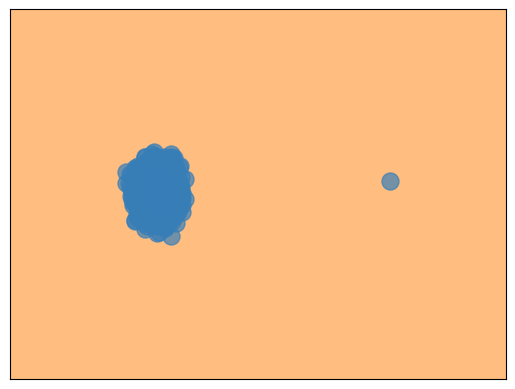

In [ ]:
contamination = 0.1

ell_env = EllipticEnvelope(contamination=contamination)
ell_env.fit(data.values)

viz_anomaly(data.values, ell_env, colors,
            n_inliers=X_train.shape[0], # мы же не обладаем предварительным знанием
            response_method="predict")

Вердикт по точкам:

In [ ]:
Counter(ell_env.support_)

Counter({True: 2828, False: 95})

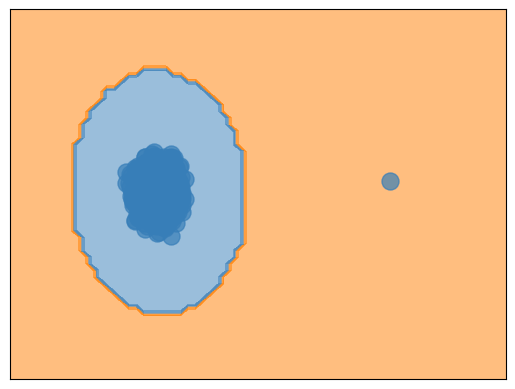

In [ ]:
contamination = 0.0003

ell_env = EllipticEnvelope(contamination=contamination)
ell_env.fit(data.values)

viz_anomaly(data.values, ell_env, colors,
            n_inliers=X_train.shape[0], # мы же не обладаем предварительным знанием
            response_method="predict")

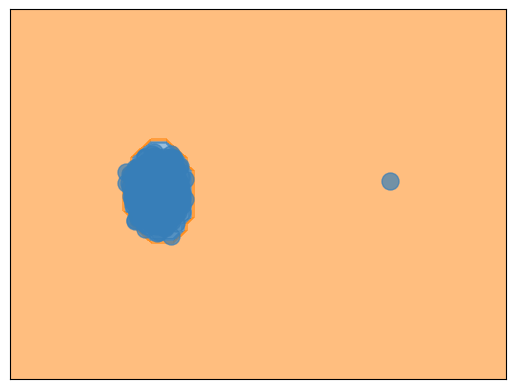

In [ ]:
contamination = 0.000345

ell_env = EllipticEnvelope(contamination=contamination)
ell_env.fit(data.values)

viz_anomaly(data.values, ell_env, colors,
            n_inliers=X_train.shape[0], # мы же не обладаем предварительным знанием
            response_method="predict")

Вердикт по точкам:

In [ ]:
Counter(ell_env.support_)

Counter({True: 2824, False: 99})

Разные значения contamination дают практически идентичный результат.

Без явного выброса:

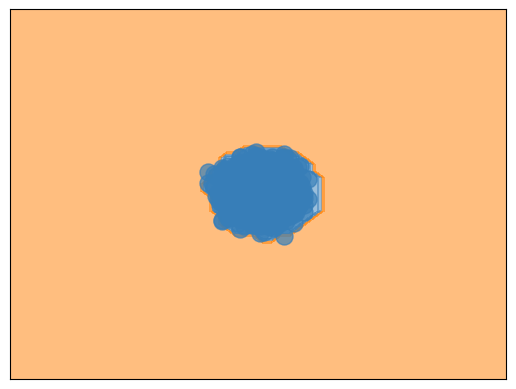

In [ ]:
contamination = 0.000345

ell_env_red = EllipticEnvelope(contamination=contamination)
ell_env_red.fit(data[data.height<=0.3].values)

viz_anomaly(data[data.height<=0.3].values, ell_env_red, colors,
            n_inliers=X_train.shape[0]-1, # мы же не обладаем предварительным знанием
            response_method="predict")

Параметры модели:

In [ ]:
ell_env.precision_

array([[760.83603561,  28.06868564],
       [ 28.06868564, 592.37395611]])

Среднее:

In [ ]:
ell_env.location_

array([0.14106763, 0.13961867])

Ковариация:

In [ ]:
ell_env.covariance_

array([[ 1.31664521e-03, -6.23871124e-05],
       [-6.23871124e-05,  1.69107894e-03]])

Методом `.score_samples()` оценивается степень "аномальности"

Тут он выдает отрицательное расстояние Махаланобиса от точки до обученного распределения

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but EllipticEnvelope was fitted without feature names
  warnings.warn(


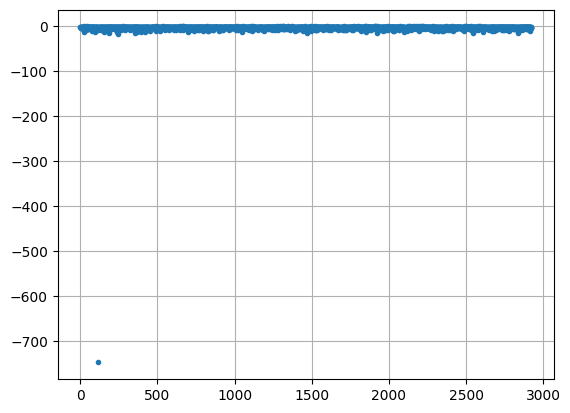

In [ ]:
plt.plot(ell_env.score_samples(data),'.',)
plt.grid();

Очевидно выпадает одно значение, есть еще некоторое количество которые все же можно отнести к аномалиям. Посмотрим:

<Axes: xlabel='height', ylabel='norm'>

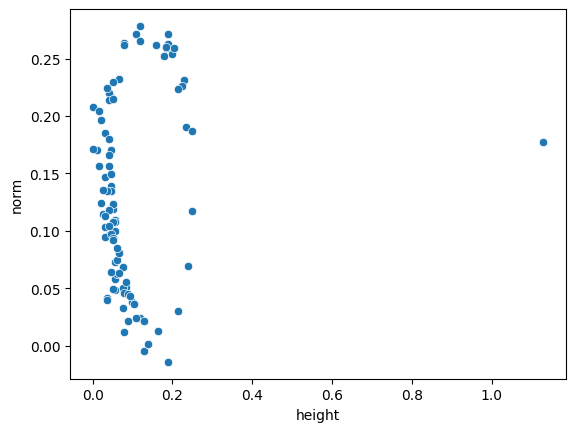

In [ ]:
anom = data.iloc[[num_des for num_des, des in enumerate(ell_env.support_) if des==False]]
sns.scatterplot(x=anom.height, y=anom.norm)

Во-первых есть выбросы по искусственному нормальному распределению, что идейно не правильно, но что поделать.

В основном аномалии по высоте в меньшую сторону, но все же достаточно плотно расположенны, что позволяет сомневаться в том, что это действительно аномалии. Это может быть связано с тем, что распределение данных все же не совсем нормальное.

Теперь посмотрим новизну:

## на test

In [ ]:
norm_test = np.random.normal(loc=X_test.height.values.mean(), scale=X_test.height.values.std(), size=X_test.shape[0])
data_test = pd.concat([X_test.height, pd.Series(norm_test, name='norm_test', index=X_test.height.index)], axis=1)
data_test.head()

,height,norm_test
17,0.100,0.172922
1131,0.150,0.085823
299,0.105,0.074466
1338,0.135,0.145081
2383,0.135,0.199191


In [ ]:
prediction = ell_env.predict(data_test)
prediction

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but EllipticEnvelope was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
Counter(prediction)

Counter({1: 1253, -1: 1})

In [ ]:
anom_test = data_test.iloc[[num_des for num_des, des in enumerate(prediction) if des==-1]]
anom_test

,height,norm_test
1417,0.515,0.12278


Поместим новую аномалию к аномалиям на трейне:

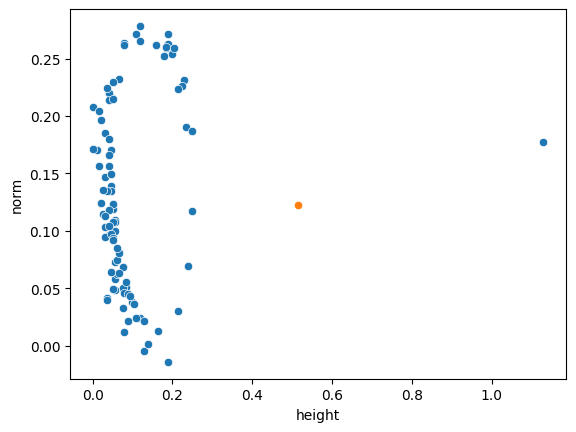

In [ ]:
sns.scatterplot(x=anom.height, y=anom.norm)
sns.scatterplot(x=anom_test.height, y=anom_test.norm_test)
plt.show()

Видно, что размер здесь сильно больше обычных значений, которые < ~0.3

# IsolationForest

## на train

Попробуем IsolationForest в тех же условиях, что и EllipticEnvelope:

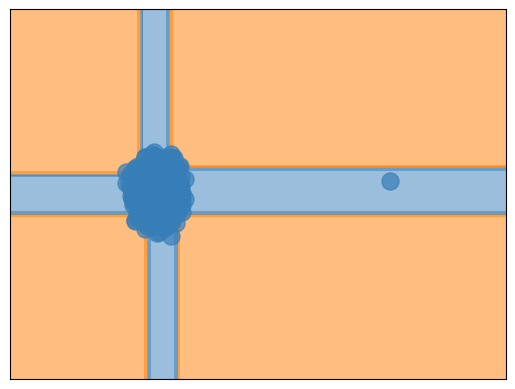

In [ ]:
contamination = 0.0008
n_estimators = 225

iso_forest = IsolationForest(contamination=contamination,
                            n_estimators=n_estimators,
                            random_state=1)

iso_forest.fit(data.values)

viz_anomaly(data.values, iso_forest, colors,
            n_inliers=X_train.shape[0], # мы же не обладаем предварительным знанием
            response_method="predict")

Это явно неподходяще значение contamination, так что снова подберем:


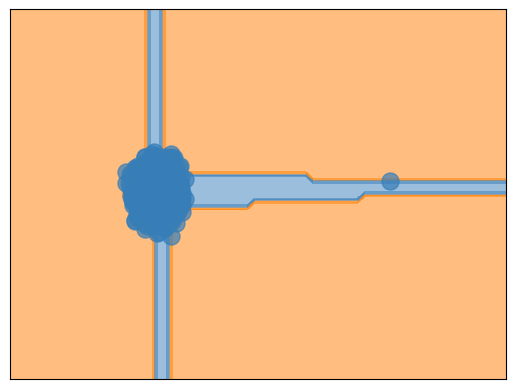

In [ ]:
contamination = 0.01
n_estimators = 225

iso_forest = IsolationForest(contamination=contamination,
                            n_estimators=n_estimators,
                            random_state=1)

iso_forest.fit(data.values)

viz_anomaly(data.values, iso_forest, colors,
            n_inliers=X_train.shape[0], # мы же не обладаем предварительным знанием
            response_method="predict")

Интересно, что он прям стремится сохранить явно ненужную точку. Еще подбираем:

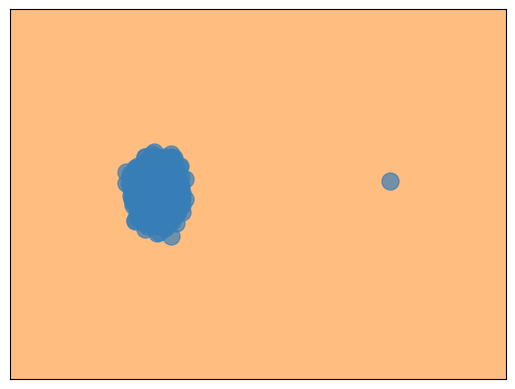

In [ ]:
contamination = 0.025
n_estimators = 1000

iso_forest = IsolationForest(contamination=contamination,
                            n_estimators=n_estimators,
                            random_state=1)

iso_forest.fit(data.values)
train_pred = iso_forest.predict(data.values)

viz_anomaly(data.values, iso_forest, colors,
            n_inliers=X_train.shape[0], # мы же не обладаем предварительным знанием
            response_method="predict")

Плохо видно, но судя по количеству выбросов, результат похож на прошлый метод

In [ ]:
Counter(train_pred)

Counter({1: 2849, -1: 74})

Параметры:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


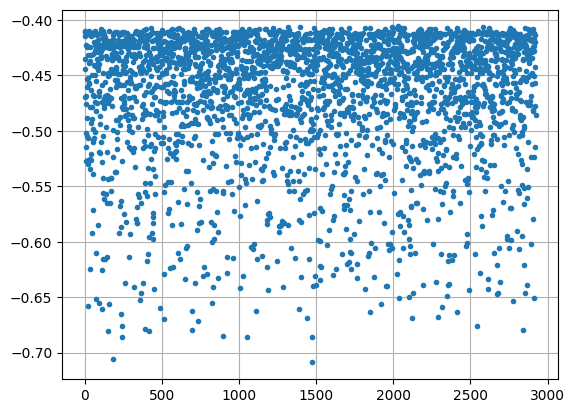

In [ ]:
plt.plot(iso_forest.score_samples(data),'.',)
plt.grid()

Посмотрим на выбросы:

<Axes: xlabel='height', ylabel='norm'>

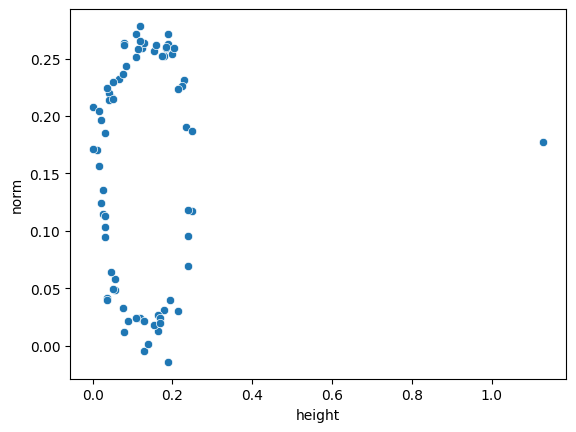

In [ ]:
second_anom_train = data.iloc[[num_des for num_des, des in enumerate(train_pred) if des==-1]]
sns.scatterplot(x=second_anom_train.height, y=second_anom_train.norm)

Похожая картина. Тоже есть выбросы по искусственному нормальному распределению, но в недостатки этого метода это записывать не будем, потому что он может работать с любыми даннми. Посмотрим новизну:

## на test

In [ ]:
test_pred = iso_forest.predict(data_test)
test_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
Counter(test_pred)

Counter({1: 1241, -1: 13})

In [ ]:
second_anom_test = data_test.iloc[[num_des for num_des, des in enumerate(test_pred) if des==-1]]
second_anom_test

,height,norm_test
1707,0.175,-0.006985
784,0.060,0.048231
2343,0.055,0.059825
2558,0.065,0.235521
1216,0.070,0.249938
525,0.040,0.222819
719,0.025,0.066332
891,0.230,0.202464
720,0.025,0.104115
1987,0.025,0.141928


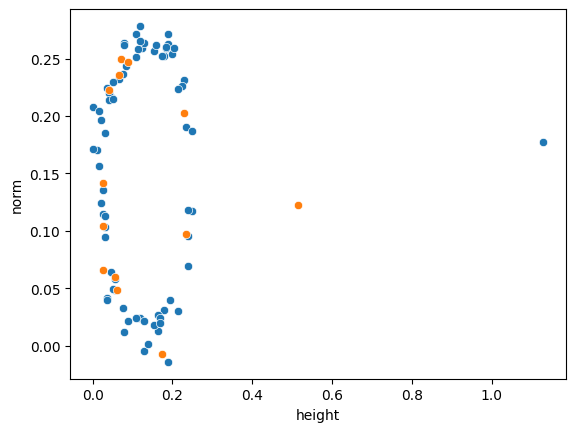

In [ ]:
sns.scatterplot(x=second_anom_train.height, y=second_anom_train.norm)
sns.scatterplot(x=second_anom_test.height, y=second_anom_test.norm_test)
plt.show()

Здесь уже больше выбросов найдено, но все они укладываются в область с выбросами на test.

В итоге:

EllipticEnvelope - есть явный недостаток связанный с условием нормальности данных
IsolationForest - да норм в целом.

Можно было бы и дальше по отдельным признаком попылить еще, но ведь это все понятно. Лучше применим понижение размерности ко всем данным, и из этого попробуем найти выбросы, с помощью того же IsolationForest.

# Понижение размерности + IsolationForest

## на train

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(random_state=1, perplexity=220, n_iter=500, metric="cosine")
tsne_data = tsne.fit_transform(X_train.values)

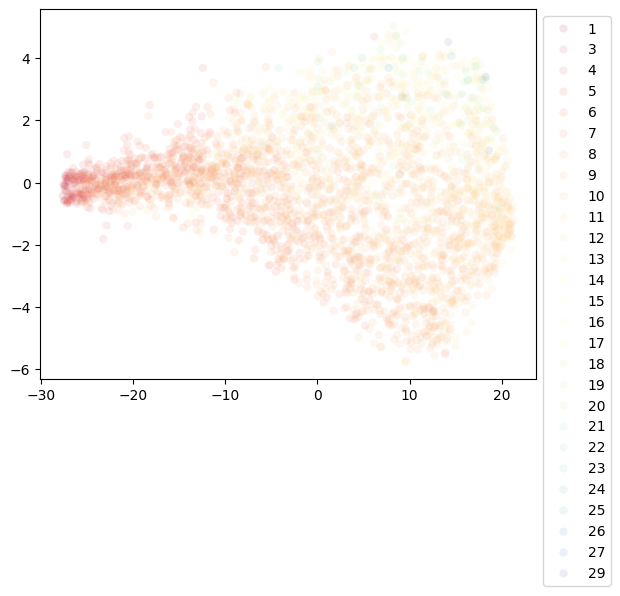

In [ ]:
ax = sns.scatterplot(x=tsne_data[:, 0],
                y=tsne_data[:, 1],
                alpha=.1,
                hue=Y_train.values,
                palette="Spectral",
                legend='full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

В таких гиперпараметрах t-sne и форма какая-то логичная, и выбросы выглядывают, на первый взгляд

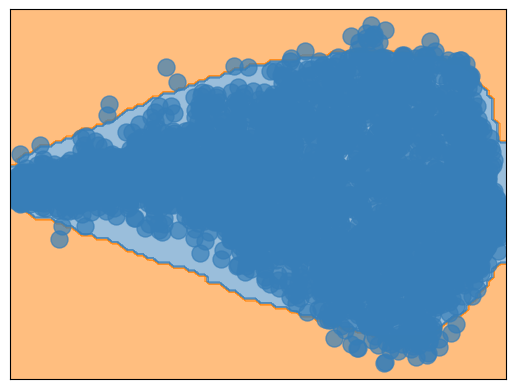

In [ ]:
contamination = 0.025
n_estimators = 1000

overall_iso_forest = IsolationForest(contamination=contamination,
                            n_estimators=n_estimators,
                            random_state=1)

overall_iso_forest.fit(tsne_data)
train_overall_pred = overall_iso_forest.predict(tsne_data)

viz_anomaly(tsne_data, overall_iso_forest, colors,
            n_inliers=X_train.shape[0], # мы же не обладаем предварительным знанием
            response_method="predict")

Вердикт по точкам:

In [ ]:
Counter(train_overall_pred)

Counter({1: 2849, -1: 74})

Уже выглядит логично, но попробуем еще подобрать:

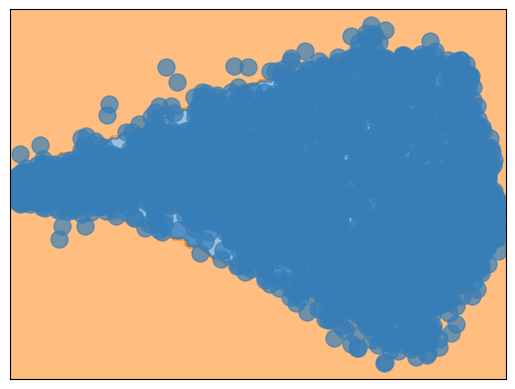

In [ ]:
contamination = 0.1
n_estimators = 1000

overall_iso_forest = IsolationForest(contamination=contamination,
                            n_estimators=n_estimators,
                            random_state=1)

overall_iso_forest.fit(tsne_data)
train_overall_pred = overall_iso_forest.predict(tsne_data)

viz_anomaly(tsne_data, overall_iso_forest, colors,
            n_inliers=X_train.shape[0], # мы же не обладаем предварительным знанием
            response_method="predict")

Вердикт по точкам:

In [ ]:
Counter(train_overall_pred)

Counter({1: 2630, -1: 293})

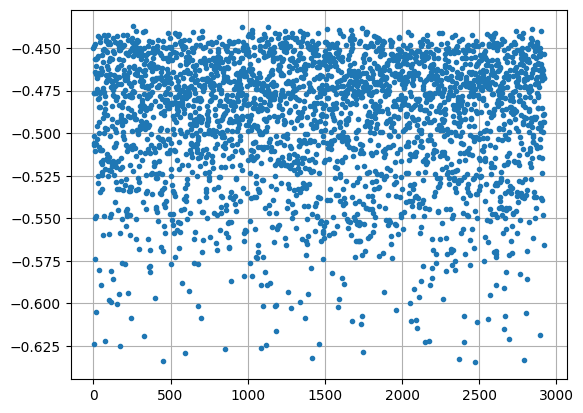

In [ ]:
plt.plot(overall_iso_forest.score_samples(tsne_data),'.',)
plt.grid()

Наверное, норм. Попробуем оценить точнее так - для каждой колонки в оригинальных данных посчитаем три СКО влево и вправо, и если аномалия в какой-то из фич выходит за эти рамки, то отнесем ее к настоящим аномалиям. И посмотим долю настоящих аномалий в предсказанных:


In [ ]:
overall_anom = X_train.iloc[[num_des for num_des, des in enumerate(train_overall_pred) if des==-1]]
true_anom_index = []
for anom_index in overall_anom.index:
  for col in X_train.columns:
    col_mean = X_train[col].mean()
    col_std = X_train[col].std()
    three_min = col_mean - 3*col_std
    three_max = col_mean + 3*col_std

    if (overall_anom.loc[anom_index][col] <= three_min \
      or overall_anom.loc[anom_index][col] >= three_max) \
      and anom_index not in true_anom_index:
      true_anom_index += [anom_index]

len(true_anom_index)/overall_anom.shape[0]

0.14334470989761092

Получается очень маленькая доля, тогда вернемся к выделению аномалий:

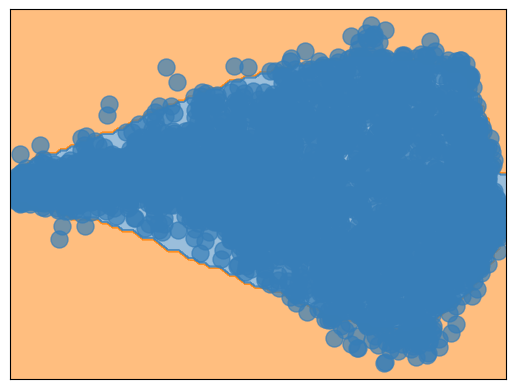

In [ ]:
contamination = 0.05
n_estimators = 1000

overall_iso_forest = IsolationForest(contamination=contamination,
                            n_estimators=n_estimators,
                            random_state=1)

overall_iso_forest.fit(tsne_data)
train_overall_pred = overall_iso_forest.predict(tsne_data)

viz_anomaly(tsne_data, overall_iso_forest, colors,
            n_inliers=X_train.shape[0], # мы же не обладаем предварительным знанием
            response_method="predict")

In [ ]:
Counter(train_overall_pred)

Counter({1: 2776, -1: 147})

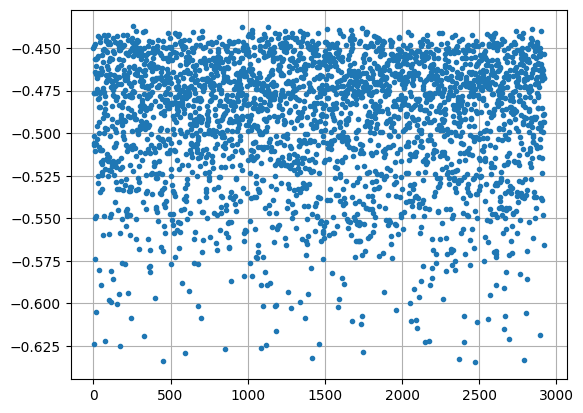

In [ ]:
plt.plot(overall_iso_forest.score_samples(tsne_data),'.',)
plt.grid()

In [ ]:
overall_anom = X_train.iloc[[num_des for num_des, des in enumerate(train_overall_pred) if des==-1]]
true_anom_index = []
for anom_index in overall_anom.index:
  for col in X_train.columns:
    col_mean = X_train[col].mean()
    col_std = X_train[col].std()
    three_min = col_mean - 3*col_std
    three_max = col_mean + 3*col_std

    if (overall_anom.loc[anom_index][col] <= three_min \
      or overall_anom.loc[anom_index][col] >= three_max) \
      and anom_index not in true_anom_index:
      true_anom_index += [anom_index]

len(true_anom_index)/overall_anom.shape[0]

0.10884353741496598

В общем, дальше, даже если ослаблять требования к аномалиям, все равно доля истинных аномалий падает. Так что здесь с методом понижения размерности не получилось.